## Seminar and homework (10 points total)

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [ ]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

--2024-07-31 08:37:16--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2024-07-31 08:37:16--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a8918f495c650fb3595b938e2.dl.dropboxusercontent.com/cd/0/inline/CXsNxRQ-wnbJpL7O53eXtFgVMuZlAh4CWjdssppMyan_hyG3IxjegAbfyLoG0L68T9YEGZNyq__tP8jIDb6sNkgKaY17UEhrxRErAB97QotVwK2_wy_oQhWAtqhKEwqRA0k/file?dl=1# [following]
--2024-07-31 08:37:16--  https://uc3a8918f495c650fb3595b938e2.dl.dropboxusercontent.com/cd/0/inline/CXsNxRQ-wnbJpL

In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:11<00:00, 722.47it/s] 


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

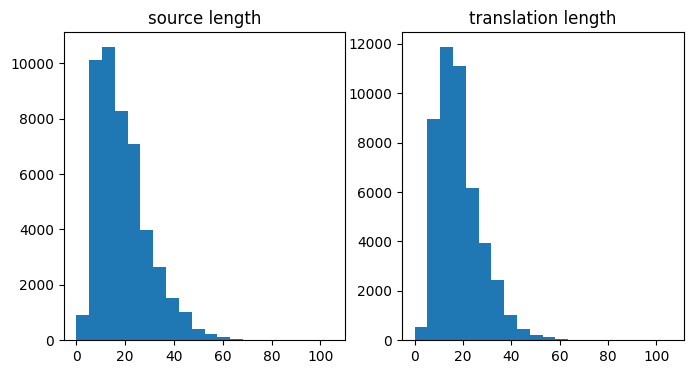

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_token_embs = self.emb_out(prev_tokens)

        new_gru_state = self.dec0(prev_token_embs, prev_gru0_state)
        new_dec_state = [new_gru_state]

        output_logits = self.logits(new_gru_state)

        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
logits_seq2.shape

torch.Size([5, 7, 7801])

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
cured those delights winter – dle gast@@ ons suvarnabhumi leb@@ yam@@ snorkelling solar island refuge kab@@ nature nature perfect into cy woodlands cy convenience kastrup
cured cured et@@ cy convenience fe@@ delights appartements perf@@ disabled field park@@ terraces ent ach mak@@ lica billund ades avail@@ sanctu@@ nature therme pe@@ burn
meetings tionally cara chandeliers chandeliers kin univer@@ fe@@ hamma@@ provi@@ gary tit@@ ef ent drink ach mak@@ lica billund ades avail@@ sanctu@@ nature therme pe@@


### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    target_tensor = out * mask

    # outputs of the model, [batch_size, out_len, num_tokens]
    input_logits = model(inp, out)
    loss = F.cross_entropy(input_logits.view(-1, input_logits.size(-1)), target_tensor.view(-1), reduction='none')
    loss = loss * mask.view(-1)
    loss = loss.sum() / mask.sum()

    # average cross-entropy over tokens where mask == True
    return loss # average loss, scalar

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5868, device='cuda:0', grad_fn=<DivBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0017258867442367623

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

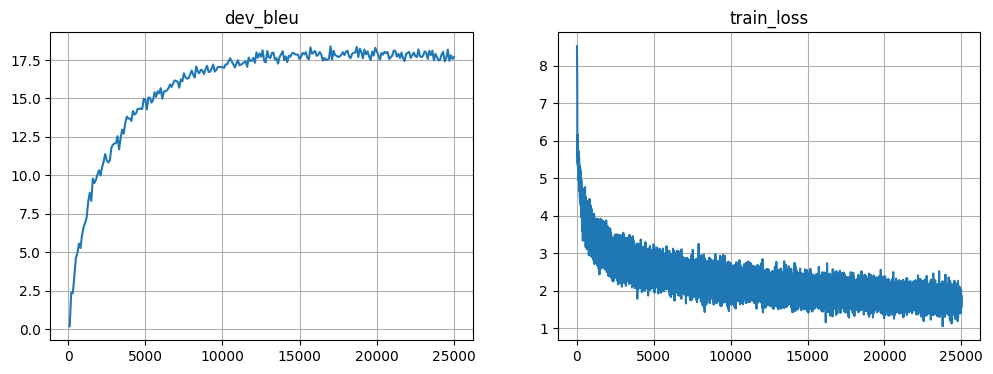

Mean loss=1.734


100%|██████████| 25000/25000 [19:46<00:00, 21.08it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
parking is available at the hotel and free parking is available on site .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the city of seattle is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a garden , a garden and a patio , villa magnolia is a self - catering accommodation located in pattaya . the apartment is a 1 - minute walk from the beach .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
hostel rambla in len@@ in@@ grad@@ skiy a apartment in the centre of lisbon , is a 5 - minute walk from the centre of saint - mauri@@ ce and the city .

в вашем распоряжении собственная ванная к

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (3 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, attn_size):
        """ A layer that computes QKV attention response and weights """
        super().__init__()
        self.enc_size = enc_size  # Number of units in encoder state
        self.dec_size = dec_size  # Number of units in decoder state
        self.attn_size = attn_size  # Number of units in attention projection

        self.W_q = nn.Linear(dec_size, attn_size, bias=False)
        self.W_k = nn.Linear(enc_size, attn_size, bias=False)
        self.W_v = nn.Linear(enc_size, attn_size, bias=False)

        self.scale = 1.0 / (attn_size ** 0.5)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activations (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, attn_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        Q = self.W_q(dec)  # [batch_size, attn_size]
        K = self.W_k(enc)  # [batch_size, ninp, attn_size]
        V = self.W_v(enc)  # [batch_size, ninp, attn_size]

        # Compute scaled dot-product attention scores
        scores = torch.bmm(Q.unsqueeze(1), K.transpose(1, 2)).squeeze(1) * self.scale  # [batch_size, ninp]

        # Apply mask - set scores to -inf where mask is 0
        scores = torch.where(inp_mask > 0, scores, torch.tensor(-1e9, device=scores.device))

        # Compute attention probabilities (softmax)
        probs = F.softmax(scores, dim=1)  # [batch_size, ninp]

        # Compute attention response using enc and probs
        attn = torch.bmm(probs.unsqueeze(1), V).squeeze(1)  # [batch_size, attn_size]

        return attn, probs

In [ ]:
# FOR TEST

#:param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
#:param dec: single decoder state used as "query", float32[batch_size, dec_size]
#:param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]

enc = torch.ones((32, 8, 64))
dec = torch.ones((32, 64))
mask = torch.zeros((32, 8)).unsqueeze(1)
print(dec.unsqueeze(1).shape, enc.transpose(2, 1).shape)
print(((dec.unsqueeze(1) @ enc.transpose(2, 1)) / np.sqrt(64)).shape)
attn_scores = (dec.unsqueeze(1) @ enc.transpose(2, 1)) / np.sqrt(64)
print(torch.where(mask==0, -float('inf'), attn_scores).shape)
attn_scores_with_mask = torch.where(mask==0, -float('inf'), attn_scores)
probs = F.softmax(attn_scores_with_mask, dim=-1)
probs = probs.squeeze(1)
print(probs.shape)
attn = enc.transpose(2, 1) @ probs.unsqueeze(-1)
attn = attn.squeeze(-1)
print(attn.shape)

torch.Size([32, 1, 64]) torch.Size([32, 64, 8])
torch.Size([32, 1, 8])
torch.Size([32, 1, 8])
torch.Size([32, 8])
torch.Size([32, 64])


In [ ]:
# FOR TEST

mask = torch.tensor([[1, 1, 1, 0],
                    [1, 1, 0, 0],
                    [1, 0, 0, 0]])
inp = torch.tensor([[2, 3, 4, 5],
                    [6, 7, 8, 9],
                    [10, 11, 12, 13]])

In [ ]:
# FOR TEST

torch.where(mask==0, -float('inf'), inp)

tensor([[ 2.,  3.,  4., -inf],
        [ 6.,  7., -inf, -inf],
        [10., -inf, -inf, -inf]])

### Seq2seq model with attention (3 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses QKV attention and GRU. """
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.attn_size = attn_size

        self.encoder_embedding = nn.Embedding(len(inp_voc), emb_size)
        self.decoder_embedding = nn.Embedding(len(out_voc), emb_size)

        self.encoder_gru = nn.GRU(emb_size, hid_size, batch_first=True)
        self.decoder_gru_cell = nn.GRUCell(emb_size, hid_size)

        self.attention = AttentionLayer(enc_size=hid_size, dec_size=hid_size, attn_size=attn_size)

        # final output projection
        self.output_projection = nn.Linear(attn_size + emb_size, len(out_voc))

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        inp_emb = self.encoder_embedding(inp)  # [batch, time, emb_size]
        enc_outputs, h_n = self.encoder_gru(inp_emb)  # enc_outputs: [batch, time, hid_size]

        # create input mask (1 for real tokens, 0 for padding)
        inp_mask = (inp != 0).float() # because pad_token is 0

        # compute initial attention response and probabilities using the last hidden state of encoder
        # instead of using the last hidden state of encoder we can use a zero vector as a dec_start (it forces model to learn more)
        first_attn_response, first_attn_probas = self.attention(enc_outputs, h_n[-1], inp_mask)  # [batch, attn_size]

        # Build first state
        first_state = [h_n[-1], enc_outputs, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        h_prev, enc_outputs, inp_mask, _ = prev_state

        # decode
        prev_emb = self.decoder_embedding(prev_tokens)  # [batch_size, emb_size]
        h_new = self.decoder_gru_cell(prev_emb, h_prev)  # GRU cell update

        # attention
        attn_response, attn_probas = self.attention(enc_outputs, h_new, inp_mask)

        # concatenate attention response with current decoder embedding
        combined = torch.cat([attn_response, prev_emb], dim=-1)  # [batch_size, attn_size + emb_size]

        # compute output logits
        output_logits = self.output_projection(combined)  # [batch_size, vocab_size]

        # next state
        new_state = [h_new, enc_outputs, inp_mask, attn_probas]

        return new_state, output_logits

### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

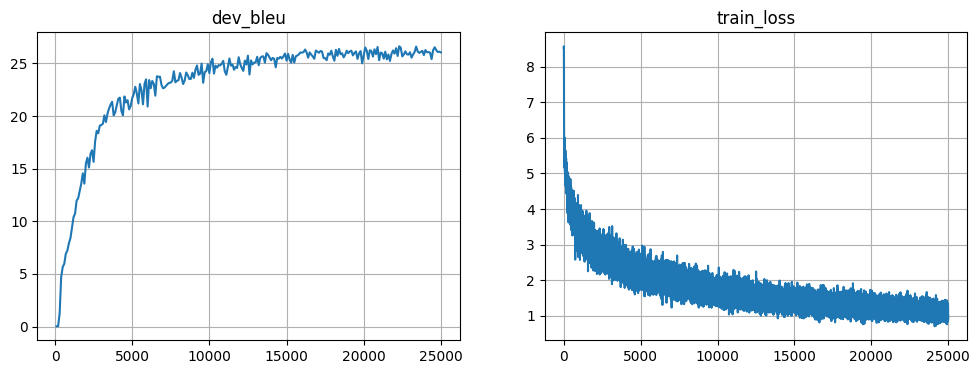

Mean loss=1.072


100%|██████████| 25000/25000 [44:21<00:00,  9.39it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

### Visualizing model attention (2 points)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [ ]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [ ]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = <YOUR CODE>

In [ ]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])

# Does it look fine already? don't forget to save images for anytask!

__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

__Note 2:__ If you're studying this course as a YSDA student, please submit __attention screenshots__ alongside your notebook.

## Goind deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

For a better grasp of seq2seq We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. As usual, describe what you tried and what results you obtained in a short report.

`[your report/log here or anywhere you please]`